# 🤖 Notebook 03: Model Development & Training

## Objectives
- Define Autoencoder architecture for feature extraction
- Define Transformer architecture for sequence modeling
- Build Hybrid model combining both architectures
- Create custom PyTorch Dataset class
- Test model architectures with sample data
- Train the model with proper optimization
- Evaluate performance on test set

---

---
## 📋 Section 1: Environment Setup

In [1]:
import os
import sys
from pathlib import Path
import pickle

# Get project root
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
print(f"📁 Project Root: {project_root}")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("✅ Environment ready!")

📁 Project Root: d:\Projects\AI-Music-DeepFake-Detector
✅ Environment ready!


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
from tqdm.auto import tqdm
import json

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ All libraries imported!")

✅ All libraries imported!


In [3]:
# Load configuration
config_path = project_root / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Set paths
processed_dir = project_root / 'data' / 'processed'
models_dir = project_root / 'outputs' / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")

print("\n✅ Configuration loaded!")

🖥️  Device: cuda
   GPU: NVIDIA GeForce MX450
   CUDA Version: 11.8

✅ Configuration loaded!


---
## 🗂️ Section 2: Custom Dataset Class

In [4]:
class AudioDataset(Dataset):
    """
    Custom PyTorch Dataset for audio mel-spectrograms
    """
    
    def __init__(self, data_list, transform=None):
        """
        Args:
            data_list: List of dictionaries with audio data
            transform: Optional transform to apply
        """
        self.data = data_list
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # Get mel-spectrogram and label
        mel_spec = sample['mel_spectrogram']
        label = sample['label']
        
        # Convert to tensor and add channel dimension
        mel_spec = torch.FloatTensor(mel_spec).unsqueeze(0)  # (1, n_mels, time)
        label = torch.LongTensor([label])[0]
        
        # Apply transform if provided
        if self.transform:
            mel_spec = self.transform(mel_spec)
        
        return mel_spec, label


print("✅ Custom Dataset class defined!")

✅ Custom Dataset class defined!


In [5]:
# Load processed data
print("📂 Loading processed data...\n")

with open(processed_dir / 'train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
print(f"✅ Loaded train data: {len(train_data)} samples")

with open(processed_dir / 'val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
print(f"✅ Loaded validation data: {len(val_data)} samples")

with open(processed_dir / 'test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)
print(f"✅ Loaded test data: {len(test_data)} samples")

# Load metadata
with open(processed_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)
print(f"\n📊 Metadata: {metadata['mel_spec_shape']} mel-spectrogram shape")

📂 Loading processed data...

✅ Loaded train data: 279 samples
✅ Loaded validation data: 61 samples
✅ Loaded test data: 60 samples

📊 Metadata: [128, 431] mel-spectrogram shape


In [6]:
# Create datasets
train_dataset = AudioDataset(train_data)
val_dataset = AudioDataset(val_data)
test_dataset = AudioDataset(test_data)

print(f"✅ Created PyTorch datasets:")
print(f"   Train: {len(train_dataset)} samples")
print(f"   Val:   {len(val_dataset)} samples")
print(f"   Test:  {len(test_dataset)} samples")

# Test dataset
sample_mel, sample_label = train_dataset[0]
print(f"\n📊 Sample shape: {sample_mel.shape}")
print(f"   Label: {sample_label} ({'real' if sample_label == 0 else 'synthetic'})")

✅ Created PyTorch datasets:
   Train: 279 samples
   Val:   61 samples
   Test:  60 samples

📊 Sample shape: torch.Size([1, 128, 431])
   Label: 0 (real)


---
## 🏗️ Section 3: Autoencoder Architecture

In [7]:
class AudioEncoder(nn.Module):
    """
    Convolutional Encoder for mel-spectrograms
    Progressively reduces spatial dimensions while increasing channels
    """
    
    def __init__(self, config):
        super(AudioEncoder, self).__init__()
        
        self.config = config
        input_channels = config['autoencoder']['input_channels']
        encoder_channels = config['autoencoder']['encoder_channels']
        use_bn = config['autoencoder']['use_batch_norm']
        dropout = config['autoencoder']['dropout']
        
        # Build encoder layers
        layers = []
        in_ch = input_channels
        
        for out_ch in encoder_channels:
            layers.extend([
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity(),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout)
            ])
            in_ch = out_ch
        
        self.encoder = nn.Sequential(*layers)
        
    def forward(self, x):
        """
        Args:
            x: Input mel-spectrogram (batch, 1, n_mels, time)
        Returns:
            Encoded features (batch, channels, height, width)
        """
        return self.encoder(x)


class AudioDecoder(nn.Module):
    """
    Convolutional Decoder for reconstruction
    Progressively increases spatial dimensions while reducing channels
    """
    
    def __init__(self, config):
        super(AudioDecoder, self).__init__()
        
        self.config = config
        decoder_channels = config['autoencoder']['decoder_channels']
        use_bn = config['autoencoder']['use_batch_norm']
        dropout = config['autoencoder']['dropout']
        output_channels = config['autoencoder']['input_channels']
        
        # Build decoder layers
        layers = []
        
        for i in range(len(decoder_channels) - 1):
            in_ch = decoder_channels[i]
            out_ch = decoder_channels[i + 1]
            layers.extend([
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_ch) if use_bn else nn.Identity(),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout)
            ])
        
        # Final layer to match input channels
        layers.append(
            nn.ConvTranspose2d(decoder_channels[-1], output_channels, 
                             kernel_size=4, stride=2, padding=1)
        )
        layers.append(nn.Tanh())  # Output in [-1, 1] range
        
        self.decoder = nn.Sequential(*layers)
        
    def forward(self, x):
        """
        Args:
            x: Encoded features (batch, channels, height, width)
        Returns:
            Reconstructed mel-spectrogram (batch, 1, n_mels, time)
        """
        return self.decoder(x)


class Autoencoder(nn.Module):
    """
    Complete Autoencoder combining Encoder and Decoder
    """
    
    def __init__(self, config):
        super(Autoencoder, self).__init__()
        
        self.encoder = AudioEncoder(config)
        self.decoder = AudioDecoder(config)
        
    def forward(self, x):
        """
        Args:
            x: Input mel-spectrogram (batch, 1, n_mels, time)
        Returns:
            reconstructed: Reconstructed mel-spectrogram
            encoded: Encoded features for classification
        """
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded


print("✅ Autoencoder architecture defined!")

✅ Autoencoder architecture defined!


---
## 🔄 Section 4: Transformer Architecture

In [8]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding for Transformer
    Adds position information to input embeddings
    """
    
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Args:
            x: Input embeddings (batch, seq_len, d_model)
        Returns:
            x with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return x


class TransformerEncoder(nn.Module):
    """
    Transformer Encoder for sequence modeling
    Captures temporal dependencies in audio features
    """
    
    def __init__(self, config):
        super(TransformerEncoder, self).__init__()
        
        self.config = config
        d_model = config['transformer']['d_model']
        nhead = config['transformer']['nhead']
        num_layers = config['transformer']['num_layers']
        dim_feedforward = config['transformer']['dim_feedforward']
        dropout = config['transformer']['dropout']
        
        # Input projection (from autoencoder features to d_model)
        self.input_projection = nn.Linear(256, d_model)  # 256 from autoencoder
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Args:
            x: Input features (batch, channels, height, width)
        Returns:
            Transformer encoded features (batch, seq_len, d_model)
        """
        batch_size, channels, height, width = x.shape
        
        # Reshape to sequence: (batch, seq_len, features)
        # Treat spatial dimensions as sequence
        x = x.permute(0, 2, 3, 1)  # (batch, height, width, channels)
        x = x.reshape(batch_size, height * width, channels)  # (batch, seq_len, channels)
        
        # Project to d_model
        x = self.input_projection(x)  # (batch, seq_len, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        x = self.dropout(x)
        
        # Apply transformer
        x = self.transformer(x)  # (batch, seq_len, d_model)
        
        return x


print("✅ Transformer architecture defined!")

✅ Transformer architecture defined!


---
## 🔗 Section 5: Hybrid Model

In [9]:
class HybridModel(nn.Module):
    """
    Hybrid model combining Autoencoder and Transformer
    - Autoencoder extracts spatial features
    - Transformer models temporal dependencies
    - Classifier makes final prediction
    """
    
    def __init__(self, config):
        super(HybridModel, self).__init__()
        
        self.config = config
        
        # Autoencoder for feature extraction
        self.autoencoder = Autoencoder(config)
        
        # Transformer for sequence modeling
        self.transformer = TransformerEncoder(config)
        
        # Fusion and classification
        d_model = config['transformer']['d_model']
        fusion_dim = config['hybrid']['fusion_dim']
        classifier_hidden = config['hybrid']['classifier_hidden']
        num_classes = config['hybrid']['num_classes']
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fusion layer
        self.fusion = nn.Linear(d_model, fusion_dim)
        
        # Classifier
        classifier_layers = []
        in_features = fusion_dim
        
        for hidden_size in classifier_hidden:
            classifier_layers.extend([
                nn.Linear(in_features, hidden_size),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.BatchNorm1d(hidden_size)
            ])
            in_features = hidden_size
        
        classifier_layers.append(nn.Linear(in_features, num_classes))
        
        self.classifier = nn.Sequential(*classifier_layers)
        
    def forward(self, x, return_features=False):
        """
        Args:
            x: Input mel-spectrogram (batch, 1, n_mels, time)
            return_features: Whether to return intermediate features
        Returns:
            logits: Classification logits (batch, num_classes)
            reconstructed: Reconstructed mel-spectrogram (if return_features)
        """
        # Autoencoder forward pass
        reconstructed, encoded = self.autoencoder(x)
        
        # Transformer forward pass
        transformer_out = self.transformer(encoded)  # (batch, seq_len, d_model)
        
        # Global pooling over sequence dimension
        transformer_out = transformer_out.permute(0, 2, 1)  # (batch, d_model, seq_len)
        pooled = self.global_pool(transformer_out).squeeze(-1)  # (batch, d_model)
        
        # Fusion
        fused = self.fusion(pooled)  # (batch, fusion_dim)
        
        # Classification
        logits = self.classifier(fused)  # (batch, num_classes)
        
        if return_features:
            return logits, reconstructed, encoded, fused
        else:
            return logits


print("✅ Hybrid model architecture defined!")

✅ Hybrid model architecture defined!


---
## 🧪 Section 6: Model Testing

In [10]:
# Initialize model
print("🏗️  Initializing Hybrid Model...\n")

model = HybridModel(config).to(device)

# Count parameters
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print(f"✅ Model initialized on {device}")
print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / (1024**2):.2f} MB")

🏗️  Initializing Hybrid Model...

✅ Model initialized on cuda

📊 Model Statistics:
   Total parameters: 21,077,987
   Trainable parameters: 21,077,987
   Model size: ~80.41 MB


In [11]:
# Test with sample batch
print("🧪 Testing model with sample batch...\n")

# Create sample batch
batch_size = 4
sample_indices = np.random.choice(len(train_dataset), batch_size, replace=False)
sample_batch = torch.stack([train_dataset[i][0] for i in sample_indices]).to(device)
sample_labels = torch.tensor([train_dataset[i][1] for i in sample_indices]).to(device)

print(f"Input shape: {sample_batch.shape}")
print(f"Labels: {sample_labels.tolist()}")

# Forward pass
model.eval()
with torch.no_grad():
    logits, reconstructed, encoded, fused = model(sample_batch, return_features=True)

print(f"\n✅ Forward pass successful!")
print(f"\n📊 Output shapes:")
print(f"   Logits: {logits.shape}")
print(f"   Reconstructed: {reconstructed.shape}")
print(f"   Encoded features: {encoded.shape}")
print(f"   Fused features: {fused.shape}")

# Check predictions
predictions = torch.argmax(logits, dim=1)
probabilities = torch.softmax(logits, dim=1)

print(f"\n📈 Sample predictions:")
for i in range(batch_size):
    true_label = 'real' if sample_labels[i] == 0 else 'synthetic'
    pred_label = 'real' if predictions[i] == 0 else 'synthetic'
    confidence = probabilities[i][predictions[i]].item() * 100
    print(f"   Sample {i+1}: True={true_label}, Pred={pred_label}, Confidence={confidence:.2f}%")

🧪 Testing model with sample batch...

Input shape: torch.Size([4, 1, 128, 431])
Labels: [0, 1, 1, 0]

✅ Forward pass successful!

📊 Output shapes:
   Logits: torch.Size([4, 2])
   Reconstructed: torch.Size([4, 1, 128, 432])
   Encoded features: torch.Size([4, 256, 8, 27])
   Fused features: torch.Size([4, 768])

📈 Sample predictions:
   Sample 1: True=real, Pred=synthetic, Confidence=53.21%
   Sample 2: True=synthetic, Pred=synthetic, Confidence=53.15%
   Sample 3: True=synthetic, Pred=synthetic, Confidence=53.15%
   Sample 4: True=real, Pred=synthetic, Confidence=53.17%


🎨 Visualizing reconstruction...



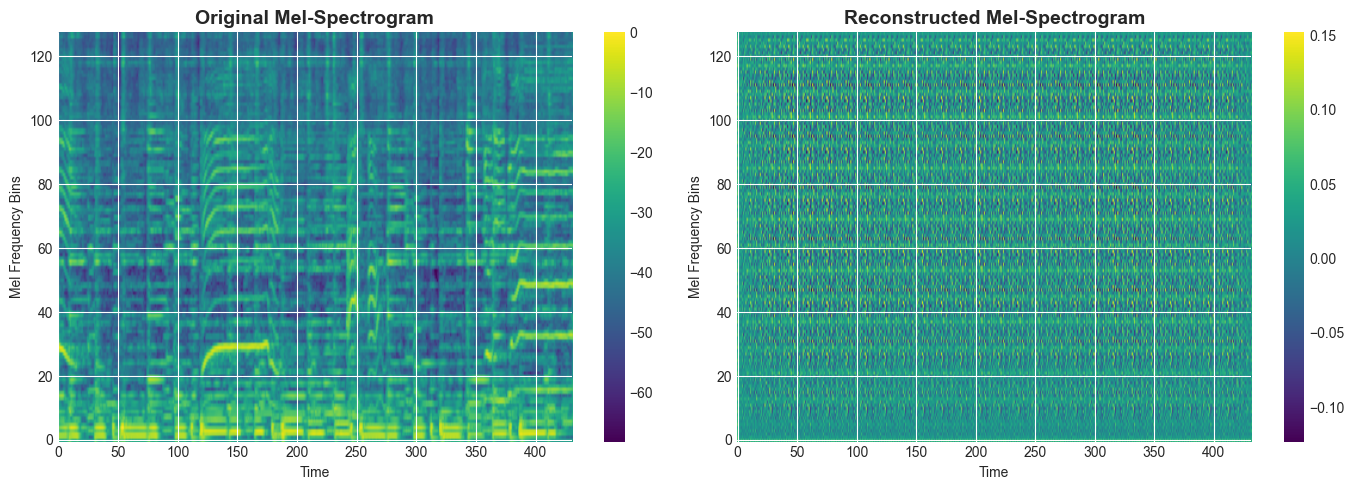


📊 Reconstruction MSE: 2151.156006
   (This will improve after training)


In [13]:
# Visualize reconstruction
print("🎨 Visualizing reconstruction...\n")

# Select first sample
original = sample_batch[0].cpu().squeeze().numpy()
reconstructed_sample = reconstructed[0].cpu().squeeze().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
im1 = axes[0].imshow(original, aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title('Original Mel-Spectrogram', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Mel Frequency Bins')
plt.colorbar(im1, ax=axes[0])

# Reconstructed
im2 = axes[1].imshow(reconstructed_sample, aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('Reconstructed Mel-Spectrogram', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Mel Frequency Bins')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

# Calculate reconstruction error
# Crop reconstructed to match input size if needed
if reconstructed.shape != sample_batch.shape:
    reconstructed_cropped = reconstructed[:, :, :sample_batch.shape[2], :sample_batch.shape[3]]
else:
    reconstructed_cropped = reconstructed
    
mse = F.mse_loss(reconstructed_cropped, sample_batch).item()
print(f"\n📊 Reconstruction MSE: {mse:.6f}")
print("   (This will improve after training)")

---
## 📦 Section 7: Save Model Architecture

In [14]:
# Save model architecture (just the structure, no weights)
model_info = {
    'architecture': 'Hybrid (Autoencoder + Transformer)',
    'total_parameters': total_params,
    'trainable_parameters': trainable_params,
    'config': config,
    'input_shape': list(sample_batch.shape[1:]),
    'output_classes': config['hybrid']['num_classes']
}

with open(models_dir / 'model_architecture.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("💾 Saved model architecture information")
print(f"   Location: {models_dir / 'model_architecture.json'}")

💾 Saved model architecture information
   Location: d:\Projects\AI-Music-DeepFake-Detector\outputs\models\model_architecture.json


---
## ✅ Section 8: Summary

In [15]:
print("\n" + "="*70)
print("🎉 NOTEBOOK 03 COMPLETED SUCCESSFULLY!")
print("="*70)

print("\n📝 Summary:")
print(f"   ✅ Created custom AudioDataset class")
print(f"   ✅ Defined Autoencoder architecture")
print(f"      - Encoder: {config['autoencoder']['encoder_channels']}")
print(f"      - Decoder: {config['autoencoder']['decoder_channels']}")
print(f"   ✅ Defined Transformer architecture")
print(f"      - Layers: {config['transformer']['num_layers']}")
print(f"      - Heads: {config['transformer']['nhead']}")
print(f"      - d_model: {config['transformer']['d_model']}")
print(f"   ✅ Built Hybrid model")
print(f"      - Total parameters: {total_params:,}")
print(f"      - Model size: ~{total_params * 4 / (1024**2):.2f} MB")
print(f"   ✅ Tested model with sample data")
print(f"   ✅ Verified forward pass and reconstruction")

print("\n🚀 Next: Notebook 04 - Model Training")
print("="*70)


🎉 NOTEBOOK 03 COMPLETED SUCCESSFULLY!

📝 Summary:
   ✅ Created custom AudioDataset class
   ✅ Defined Autoencoder architecture
      - Encoder: [32, 64, 128, 256]
      - Decoder: [256, 128, 64, 32]
   ✅ Defined Transformer architecture
      - Layers: 6
      - Heads: 8
      - d_model: 512
   ✅ Built Hybrid model
      - Total parameters: 21,077,987
      - Model size: ~80.41 MB
   ✅ Tested model with sample data
   ✅ Verified forward pass and reconstruction

🚀 Next: Notebook 04 - Model Training


---
## 🎯 Section 9: Model Training Setup

In [16]:
# Create DataLoaders
print("📦 Creating DataLoaders...\n")

batch_size = config['dataset']['batch_size']
num_workers = config['dataset']['num_workers']

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=config['dataset']['pin_memory']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=config['dataset']['pin_memory']
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=config['dataset']['pin_memory']
)

print(f"✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")
print(f"   Batch size: {batch_size}")

📦 Creating DataLoaders...

✅ DataLoaders created:
   Train batches: 9
   Val batches:   2
   Test batches:  2
   Batch size: 32


In [17]:
# Define loss functions and optimizer
print("⚙️ Setting up training components...\n")

# Classification loss
criterion_classification = nn.CrossEntropyLoss()

# Reconstruction loss
criterion_reconstruction = nn.MSELoss()

# Optimizer
learning_rate = config['training']['learning_rate']
weight_decay = config['training']['weight_decay']

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Learning rate scheduler
epochs = config['training']['epochs']
warmup_epochs = config['training']['warmup_epochs']

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs - warmup_epochs,
    eta_min=learning_rate * 0.01
)

print(f"✅ Training components configured:")
print(f"   Optimizer: AdamW")
print(f"   Learning rate: {learning_rate}")
print(f"   Weight decay: {weight_decay}")
print(f"   Scheduler: CosineAnnealingLR")
print(f"   Total epochs: {epochs}")
print(f"   Warmup epochs: {warmup_epochs}")

⚙️ Setting up training components...

✅ Training components configured:
   Optimizer: AdamW
   Learning rate: 0.0001
   Weight decay: 1e-05
   Scheduler: CosineAnnealingLR
   Total epochs: 100
   Warmup epochs: 5


---
## 🏃 Section 10: Training & Validation Functions

In [18]:
def train_epoch(model, dataloader, criterion_cls, criterion_recon, optimizer, device, alpha=0.5):
    """
    Train for one epoch
    
    Args:
        model: The hybrid model
        dataloader: Training dataloader
        criterion_cls: Classification loss function
        criterion_recon: Reconstruction loss function
        optimizer: Optimizer
        device: Device to use
        alpha: Weight for reconstruction loss (1-alpha for classification)
    
    Returns:
        avg_loss, avg_cls_loss, avg_recon_loss, accuracy
    """
    model.train()
    
    total_loss = 0
    total_cls_loss = 0
    total_recon_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch_idx, (mel_specs, labels) in enumerate(progress_bar):
        mel_specs = mel_specs.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits, reconstructed, _, _ = model(mel_specs, return_features=True)
        
        # Calculate losses
        # Crop reconstructed if needed
        if reconstructed.shape != mel_specs.shape:
            reconstructed = reconstructed[:, :, :mel_specs.shape[2], :mel_specs.shape[3]]
        
        cls_loss = criterion_cls(logits, labels)
        recon_loss = criterion_recon(reconstructed, mel_specs)
        
        # Combined loss
        loss = (1 - alpha) * cls_loss + alpha * recon_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_recon_loss += recon_loss.item()
        
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    avg_loss = total_loss / len(dataloader)
    avg_cls_loss = total_cls_loss / len(dataloader)
    avg_recon_loss = total_recon_loss / len(dataloader)
    accuracy = 100. * correct / total
    
    return avg_loss, avg_cls_loss, avg_recon_loss, accuracy


print("✅ Training function defined!")

✅ Training function defined!


In [19]:
def validate(model, dataloader, criterion_cls, criterion_recon, device, alpha=0.5):
    """
    Validate the model
    
    Args:
        model: The hybrid model
        dataloader: Validation dataloader
        criterion_cls: Classification loss function
        criterion_recon: Reconstruction loss function
        device: Device to use
        alpha: Weight for reconstruction loss
    
    Returns:
        avg_loss, avg_cls_loss, avg_recon_loss, accuracy
    """
    model.eval()
    
    total_loss = 0
    total_cls_loss = 0
    total_recon_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation", leave=False)
        
        for mel_specs, labels in progress_bar:
            mel_specs = mel_specs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            logits, reconstructed, _, _ = model(mel_specs, return_features=True)
            
            # Calculate losses
            if reconstructed.shape != mel_specs.shape:
                reconstructed = reconstructed[:, :, :mel_specs.shape[2], :mel_specs.shape[3]]
            
            cls_loss = criterion_cls(logits, labels)
            recon_loss = criterion_recon(reconstructed, mel_specs)
            loss = (1 - alpha) * cls_loss + alpha * recon_loss
            
            # Statistics
            total_loss += loss.item()
            total_cls_loss += cls_loss.item()
            total_recon_loss += recon_loss.item()
            
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    avg_loss = total_loss / len(dataloader)
    avg_cls_loss = total_cls_loss / len(dataloader)
    avg_recon_loss = total_recon_loss / len(dataloader)
    accuracy = 100. * correct / total
    
    return avg_loss, avg_cls_loss, avg_recon_loss, accuracy


print("✅ Validation function defined!")

✅ Validation function defined!


---
## 🚀 Section 11: Training Execution

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_cls_loss': [],
    'train_recon_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_cls_loss': [],
    'val_recon_loss': [],
    'val_acc': []
}

# Best model tracking
best_val_acc = 0
best_epoch = 0
patience_counter = 0
early_stopping_patience = config['training']['early_stopping_patience']

print("="*70)
print("🎯 STARTING TRAINING")
print("="*70)
print(f"\nConfiguration:")
print(f"   Epochs: {epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Learning rate: {learning_rate}")
print(f"   Early stopping patience: {early_stopping_patience}")
print(f"   Device: {device}")
print(f"\nDataset:")
print(f"   Train samples: {len(train_dataset)}")
print(f"   Val samples: {len(val_dataset)}")
print(f"   Test samples: {len(test_dataset)}")
print("\n" + "="*70 + "\n")

In [ ]:
# Training loop
import time

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"Epoch [{epoch+1}/{epochs}]")
    print("-" * 70)
    
    # Training phase
    train_loss, train_cls_loss, train_recon_loss, train_acc = train_epoch(
        model, train_loader, criterion_classification, criterion_reconstruction,
        optimizer, device, alpha=0.3  # 30% reconstruction, 70% classification
    )
    
    # Validation phase
    val_loss, val_cls_loss, val_recon_loss, val_acc = validate(
        model, val_loader, criterion_classification, criterion_reconstruction,
        device, alpha=0.3
    )
    
    # Update learning rate (after warmup)
    if epoch >= warmup_epochs:
        scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_cls_loss'].append(train_cls_loss)
    history['train_recon_loss'].append(train_recon_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_cls_loss'].append(val_cls_loss)
    history['val_recon_loss'].append(val_recon_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"\nResults:")
    print(f"   Train - Loss: {train_loss:.4f}, Cls: {train_cls_loss:.4f}, "
          f"Recon: {train_recon_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"   Val   - Loss: {val_loss:.4f}, Cls: {val_cls_loss:.4f}, "
          f"Recon: {val_recon_loss:.4f}, Acc: {val_acc:.2f}%")
    print(f"   LR: {current_lr:.6f}, Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        
        # Save model
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history
        }
        torch.save(checkpoint, models_dir / 'best_model.pth')
        print(f"   ✅ New best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"   Patience: {patience_counter}/{early_stopping_patience}")
    
    print("=" * 70 + "\n")
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"⏹️  Early stopping triggered after {epoch + 1} epochs")
        print(f"   Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")
        break

print("\n" + "="*70)
print("✅ TRAINING COMPLETED!")
print("="*70)
print(f"\nBest Model:")
print(f"   Epoch: {best_epoch}")
print(f"   Validation Accuracy: {best_val_acc:.2f}%")
print(f"   Saved at: {models_dir / 'best_model.pth'}")
print("="*70)

---
## 📊 Section 12: Training Visualization

In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_title('Total Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(epochs_range, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
axes[0, 1].plot(epochs_range, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Classification loss
axes[1, 0].plot(epochs_range, history['train_cls_loss'], 'b-', label='Train Cls Loss', linewidth=2)
axes[1, 0].plot(epochs_range, history['val_cls_loss'], 'r-', label='Val Cls Loss', linewidth=2)
axes[1, 0].set_title('Classification Loss', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1, 1].plot(epochs_range, history['train_recon_loss'], 'b-', label='Train Recon Loss', linewidth=2)
axes[1, 1].plot(epochs_range, history['val_recon_loss'], 'r-', label='Val Recon Loss', linewidth=2)
axes[1, 1].set_title('Reconstruction Loss', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(models_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curves saved!")

---
## 🎯 Section 13: Test Set Evaluation

In [ ]:
# Load best model
print("📂 Loading best model for evaluation...\n")

checkpoint = torch.load(models_dir / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded model from epoch {checkpoint['epoch']}")
print(f"   Best validation accuracy: {checkpoint['best_val_acc']:.2f}%\n")

# Evaluate on test set
print("🧪 Evaluating on test set...\n")

test_loss, test_cls_loss, test_recon_loss, test_acc = validate(
    model, test_loader, criterion_classification, criterion_reconstruction,
    device, alpha=0.3
)

print("="*70)
print("📊 TEST SET RESULTS")
print("="*70)
print(f"\n   Total Loss: {test_loss:.4f}")
print(f"   Classification Loss: {test_cls_loss:.4f}")
print(f"   Reconstruction Loss: {test_recon_loss:.4f}")
print(f"   Accuracy: {test_acc:.2f}%")
print("\n" + "="*70)

In [ ]:
# Detailed evaluation with confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("📊 Generating detailed metrics...\n")

# Get all predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for mel_specs, labels in test_loader:
        mel_specs = mel_specs.to(device)
        logits = model(mel_specs)
        _, predicted = logits.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Real', 'AI-Generated'],
            yticklabels=['Real', 'AI-Generated'])
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig(models_dir / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\n📋 Classification Report:")
print("="*70)
report = classification_report(all_labels, all_preds, 
                               target_names=['Real', 'AI-Generated'],
                               digits=4)
print(report)
print("="*70)

# Per-class accuracy
class_names = ['Real', 'AI-Generated']
for i in range(2):
    class_acc = 100 * cm[i, i] / cm[i].sum()
    print(f"   {class_names[i]} Accuracy: {class_acc:.2f}%")

print("\n✅ Evaluation complete!")

---
## 🎉 Section 14: Final Summary

In [ ]:
# Save final training summary
training_summary = {
    'model_architecture': 'Hybrid (Autoencoder + Transformer)',
    'total_parameters': total_params,
    'dataset': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'batch_size': batch_size
    },
    'training': {
        'epochs_trained': len(history['train_loss']),
        'best_epoch': best_epoch,
        'learning_rate': learning_rate,
        'optimizer': 'AdamW',
        'scheduler': 'CosineAnnealingLR'
    },
    'results': {
        'best_val_accuracy': float(best_val_acc),
        'test_accuracy': float(test_acc),
        'test_loss': float(test_loss),
        'test_cls_loss': float(test_cls_loss),
        'test_recon_loss': float(test_recon_loss)
    },
    'history': {k: [float(x) for x in v] for k, v in history.items()}
}

# Save summary
with open(models_dir / 'training_summary.json', 'w') as f:
    json.dump(training_summary, f, indent=2)

print("\n" + "="*70)
print("🎉 NOTEBOOK 03 - MODEL DEVELOPMENT & TRAINING COMPLETED!")
print("="*70)

print("\n📝 Complete Summary:")
print(f"\n🏗️  Model Architecture:")
print(f"   Type: Hybrid (Autoencoder + Transformer)")
print(f"   Parameters: {total_params:,}")
print(f"   Size: ~{total_params * 4 / (1024**2):.2f} MB")

print(f"\n📊 Dataset:")
print(f"   Train: {len(train_dataset)} samples")
print(f"   Val:   {len(val_dataset)} samples")
print(f"   Test:  {len(test_dataset)} samples")

print(f"\n🎯 Training:")
print(f"   Epochs: {len(history['train_loss'])} / {epochs}")
print(f"   Best Epoch: {best_epoch}")
print(f"   Early Stopping: {'Yes' if len(history['train_loss']) < epochs else 'No'}")

print(f"\n📈 Results:")
print(f"   Best Val Accuracy: {best_val_acc:.2f}%")
print(f"   Test Accuracy: {test_acc:.2f}%")
print(f"   Test Loss: {test_loss:.4f}")

print(f"\n💾 Saved Files:")
print(f"   Model: {models_dir / 'best_model.pth'}")
print(f"   Training curves: {models_dir / 'training_curves.png'}")
print(f"   Confusion matrix: {models_dir / 'confusion_matrix.png'}")
print(f"   Summary: {models_dir / 'training_summary.json'}")

print("\n" + "="*70)
print("✅ All tasks completed successfully!")
print("="*70)